In [2]:
import sys
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from matplotlib.ticker import PercentFormatter

<h2>Recombination rates</h2>

In [71]:
#Load in recombination data
df = pd.read_csv(r"/home/vivak/human_demog_DFE/GRCh37_functionalMasked_500bp_1kG_accessibility_recRates.bed", sep='\t', 
                 names=['chrom','start','end','length','unmasked_length', 'r', 'overlap'])
#Create df of duplicates (ie regions that cross recombination bins)
df2 = df[df.duplicated(['chrom','start','end'])].drop_duplicates(['chrom','start','end'])
#Create lists of various columns
chroms = list(df2.chrom)
starts = list(df2.start)
ends = list(df2.end)
lengths = list(df2.length)
unmasked = list(df2.unmasked_length)

In [72]:
res = []
#Loop through duplicates
for i,j in enumerate(chroms):
    #Create df of current duplicate
    tdf = df[(df.chrom==chroms[i]) & (df.start==starts[i]) & (df.end==ends[i])].copy()
    #Adjust recombination rate relative to the size of the coverage
    tdf['r'] = tdf['r'] * (tdf['overlap'] / tdf['length'])
    #Create list that will act as row in df and append
    res.append([chroms[i],starts[i],ends[i],lengths[i],unmasked[i], tdf.r.mean(), tdf.overlap.sum()])
#Remove duplicates from main df    
df.drop_duplicates(['chrom','start','end'], inplace=True, keep=False)
#Create df from duplicated data
ddf = pd.DataFrame(res, columns=['chrom','start','end','length','unmasked_length', 'r', 'overlap'])
#Concatenate dfs
rdf = pd.concat([df, ddf])

#Create empty df to store sorted data
df = pd.DataFrame()
for i in range(1, 23):
    #Subset by chromosome, sort by start coordinate, then concatenate with df
    tdf = rdf[rdf.chrom == "chr" + str(i)]
    tdf = tdf.sort_values("start")
    df = pd.concat([df, tdf])
    
#Remove regions that don't have complete coverage
df = df[df.overlap >= df.length]

<h2>Mutation Rates</h2>

In [73]:
#Load in recombination data
mdf = pd.read_csv(r"/home/vivak/human_demog_DFE/GRCh37_functionalMasked_500bp_1kG_accessibility_mutRates.bed", sep='\t', 
                 names=['chrom','start','end','length','unmasked_length', 'm', 'overlap'])
#Create df of duplicates (ie regions that cross recombination bins)
mdf2 = mdf[mdf.duplicated(['chrom','start','end'])].drop_duplicates(['chrom','start','end'])
#Create lists of various columns
chroms = list(mdf2.chrom)
starts = list(mdf2.start)
ends = list(mdf2.end)
lengths = list(mdf2.length)
unmasked = list(mdf2.unmasked_length)

In [74]:
res = []
#Loop through duplicates
for i,j in enumerate(chroms):
    #Create df of current duplicate
    tdf = mdf[(mdf.chrom==chroms[i]) & (mdf.start==starts[i]) & (mdf.end==ends[i])].copy()
    #Adjust recombination rate relative to the size of the coverage
    tdf['m'] = tdf['m'] * (tdf['overlap'] / tdf['length'])
    #Create list that will act as row in df and append
    res.append([chroms[i],starts[i],ends[i],lengths[i],unmasked[i], tdf.m.mean(), tdf.overlap.sum()])
#Remove duplicates from main df    
mdf.drop_duplicates(['chrom','start','end'], inplace=True, keep=False)
#Create df from duplicated data
ddf = pd.DataFrame(res, columns=['chrom','start','end','length','unmasked_length', 'm', 'overlap'])
#Concatenate dfs
rdf = pd.concat([mdf, ddf])

#Create empty df to store sorted data
mdf = pd.DataFrame()
for i in range(1, 23):
    #Subset by chromosome, sort by start coordinate, then concatenate with df
    tdf = rdf[rdf.chrom == "chr" + str(i)]
    tdf = tdf.sort_values("start")
    mdf = pd.concat([mdf, tdf])
    
#Remove regions that don't have complete coverage
mdf = mdf[mdf.overlap >= mdf.length]
mdf = mdf[['chrom','start','end','m']]
df = pd.merge(df, mdf, on=['chrom','start','end'], how='inner')
df = df.drop(columns=['overlap'])

In [75]:
# df = df.reset_index(drop=True)
# df['region'] = df.index + 1
#df.to_csv(r"/home/vivak/human_demog_DFE/GRCh37_functionalMasked_all.bed", sep='\t', header=True, index=False)
df = df[df.unmasked_length > 15000]
df = df.reset_index(drop=True)
df['region'] = df.index + 1
df.to_csv(r"/home/vivak/human_demog_DFE/GRCh37_functionalMasked_15kb.bed", sep='\t', header=True, index=False)

<h2>Plot length, mutation rate and recombination rate distributions</h2>

In [3]:
df = pd.read_csv(r"/home/vivak/human_demog_DFE/GRCh37_functionalMasked_15kb.bed", sep='\t', header=0)
df.head()

,chrom,start,end,length,unmasked_length,r,m,region
0,chr1,103172317,103228400,56083,20246,0.147785,2.444865e-08,1
1,chr1,105041569,105125200,83631,17543,0.019551,2.371485e-08,2
2,chr1,163908400,163970870,62470,20208,0.102214,2.512013e-08,3
3,chr1,189410800,189472066,61266,22675,0.000000,2.658147e-08,4
4,chr1,194591000,194664328,73328,18558,0.000000,2.194914e-08,5


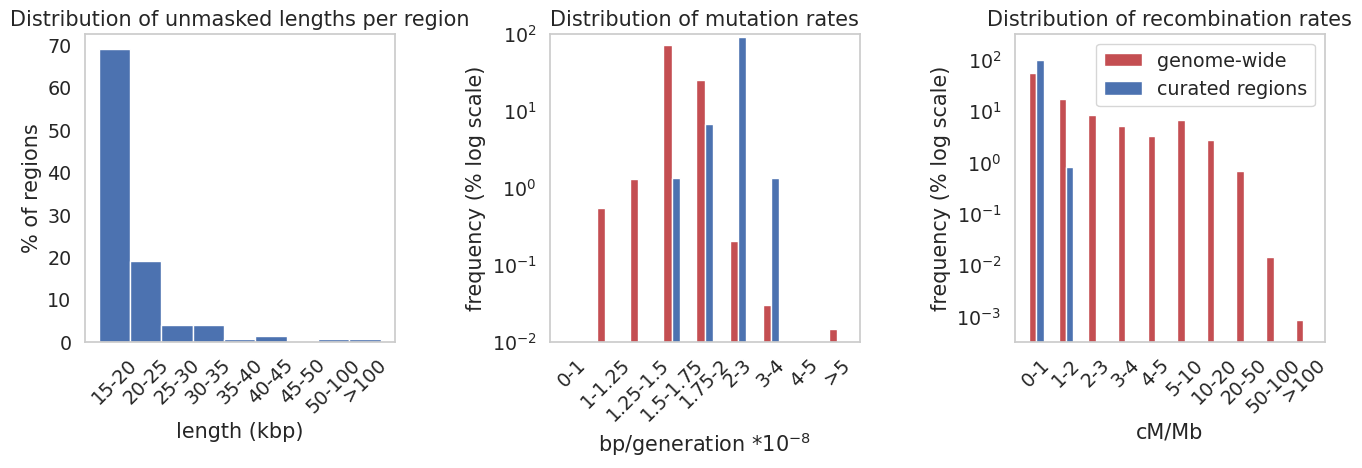

In [6]:
sns.set(rc={'figure.figsize':(16, 4),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
plt.subplot(1,3,1)
b = [15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 100000, 500000]
df['l_bin'] = pd.cut(df.unmasked_length, b, labels=[x for x in range(1,10)])
labs = list(df.l_bin.value_counts().sort_index().index)
vals = df.l_bin.value_counts().sort_index().values
s = np.sum(vals)
vals = (vals / s) * 100      
plt.bar(labs, vals, color='b', width=1, label='genome-wide')                     
plt.xticks(labs, labels=['15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-100', '>100'], rotation=45)
plt.xlabel('length (kbp)')
plt.ylabel('% of regions')
plt.title('Distribution of unmasked lengths per region')

# plt.subplot(2,2,2)
# b = [0, 100, 500, 600, 700, 800, 900, 1000, 1500, 2000, 200000]
# df['s_bin'] = pd.cut(df.snps, b, labels=[x for x in range(1,11)])
# labs = list(df.s_bin.value_counts().sort_index().index)
# vals = df.s_bin.value_counts().sort_index().values
# s = np.sum(vals)
# vals = (vals / s) * 100      
# plt.bar(labs, vals, color='b', width=1)                     
# plt.xticks(labs, labels=['0-100', '100-500', '500-600', '600-700', '700-800', '800-900', '900-1,000', '1,000-1,500', '1,500-2,000',
#                          '>2,000'], 
#            rotation=45)
# plt.xlabel('snps')
# plt.ylabel('% of regions')
# plt.title('Distribution of snps per region')


plt.subplot(1,3,2)
b = [0, 1e-8, 1.25e-8, 1.5e-8, 1.75e-8, 2e-8, 3e-8, 4e-8, 5e-8, 1e-7]
#b = np.append(b, mdf.m.max()+1)
mdf = pd.read_csv(r"/home/vivak/human_demog_DFE/mutationRates/20kb_wins_meanRates.bed", sep='\t', 
                 names=['chrom','start','end','m'])
mdf['m'] = (mdf.m / 7) / (4 * 10000)
mdf['m_bin'] = pd.cut(mdf.m, b, labels=[x for x in range(1,10)])
labs = list(mdf.m_bin.value_counts().sort_index().index)
vals = mdf.m_bin.value_counts().sort_index().values
s = np.sum(vals)
vals = (vals / s) * 100
plt.bar([x-0.125 for x in labs], vals, color='r', width=0.25, label='genome-wide')
plt.xticks(labs, 
           ["0-1", "1-1.25", "1.25-1.5", "1.5-1.75", "1.75-2", "2-3", "3-4", "4-5", ">5"],
          rotation=45)

b = [0, 1e-8, 1.25e-8, 1.5e-8, 1.75e-8, 2e-8, 3e-8, 4e-8, 5e-8, 1e-7]
#b = np.append(b, mdf.m.max()+1)
df['m_bin'] = pd.cut(df.m, b, labels=[x for x in range(1,10)])
labs = list(df.m_bin.value_counts().sort_index().index)
vals = df.m_bin.value_counts().sort_index().values
s = np.sum(vals)
vals = (vals / s) * 100
plt.bar([x+0.125 for x in labs], vals, color='b', width=0.25, label='non-functional regions')
plt.xticks(labs, 
           ["0-1", "1-1.25", "1.25-1.5", "1.5-1.75", "1.75-2", "2-3", "3-4", "4-5", ">5"],
          rotation=45)
plt.yscale('log')
plt.xlabel(r'bp/generation ' + r'$* 10^{-8}$')
plt.ylabel('frequency (% log scale)')
plt.title('Distribution of mutation rates')
plt.ylim( (pow(10,-2),pow(10,2)))

plt.subplot(1,3,3)
b = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 120]
#b = np.append(b, mdf.m.max()+1)
rdf = pd.read_csv(r"/home/vivak/human_demog_DFE/recombinationRates/SexAveraged.bedgraph", sep='\t', 
                 names=['chrom','start','end','r'])
rdf['r_bin'] = pd.cut(rdf.r, b, labels=[x for x in range(1,11)])
labs = list(rdf.r_bin.value_counts().sort_index().index)
vals = rdf.r_bin.value_counts().sort_index().values
s = np.sum(vals)
vals = (vals / s) * 100
plt.bar([x-0.125 for x in labs], vals, color='r', width=0.25, label='genome-wide')
plt.xticks(labs, 
           ["0-1", "1-2", "2-3", "3-4", "4-5", "5-10", "10-20", "20-50", "50-100", ">100"],
          rotation=45)

df['r_bin'] = pd.cut(df.r, b, labels=[x for x in range(1,11)])
labs = list(df.r_bin.value_counts().sort_index().index)
vals = df.r_bin.value_counts().sort_index().values
s = np.sum(vals)
vals = (vals / s) * 100
plt.bar([x+0.125 for x in labs], vals, color='b', width=0.25, label='curated regions')
plt.xticks(labs, 
           ["0-1", "1-2", "2-3", "3-4", "4-5", "5-10", "10-20", "20-50", "50-100", ">100"],
          rotation=45)
plt.yscale('log')
plt.xlabel('cM/Mb')
plt.ylabel('frequency (% log scale)')
plt.title('Distribution of recombination rates')
plt.ylim( (pow(10,-3.5),pow(10,2.5)))
plt.legend()

plt.subplots_adjust(wspace=0.5, hspace=1)

plt.savefig('/home/vivak/human_demog_DFE/plots/nonfunc_regions.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig('/home/vivak/human_demog_DFE/plots/nonfunc_regions.tiff', format='tiff', dpi=300, bbox_inches='tight')